In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Helper to construct covariance matrix from eigenvectors and eigenvalues
def construct_cov_matrix(lambdas, theta):
    u1 = np.array([np.cos(theta), np.sin(theta)])
    u2 = np.array([-np.sin(theta), np.cos(theta)])
    U = np.stack([u1, u2], axis=1)  # each column is an eigenvector
    L = np.diag(lambdas)
    cov = U @ L @ U.T
    return cov

# Define parameters
pi_C, pi_D = 0.75, 0.25
mu_C = np.array([0, 0])
mu_D = np.array([-6, -4])

theta_C = np.pi / 3
theta_D = np.pi / 4

cov_C = construct_cov_matrix([1, 2], theta_C)
cov_D = construct_cov_matrix([2, 1], theta_D)

# Generate 200 samples
n = 200
n_C = int(pi_C * n)
n_D = n - n_C

np.random.seed(42)
X_C = np.random.multivariate_normal(mu_C, cov_C, n_C)
X_D = np.random.multivariate_normal(mu_D, cov_D, n_D)
X = np.vstack([X_C, X_D])


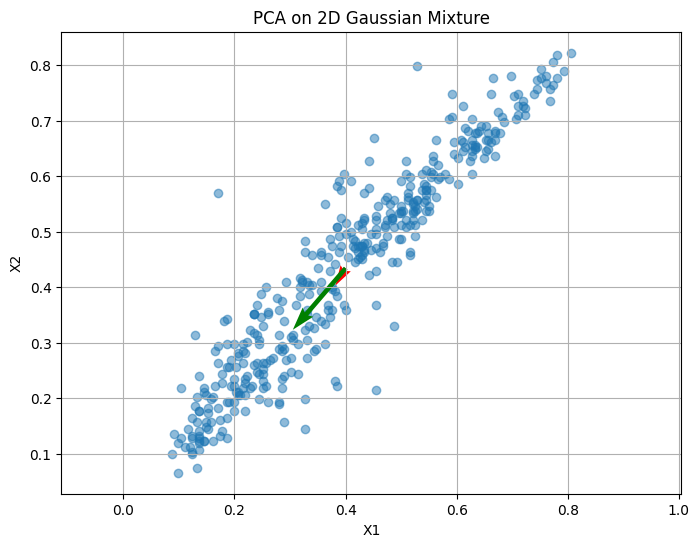

In [6]:
def pca(X):
    X_centered = X - X.mean(axis=0)
    cov = np.cov(X_centered.T)
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    return eigvecs[:, idx], eigvals[idx]

# Compute PCA
eigvecs, eigvals = pca(X)
mean = X.mean(axis=0)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.5)
for i in range(2):
    v = eigvecs[:, i]
    plt.quiver(mean[0], mean[1], v[0], v[1], 
               scale=1/np.sqrt(eigvals[i]), angles='xy', scale_units='xy', color=['red', 'green'][i])
plt.axis('equal')
plt.title('PCA on 2D Gaussian Mixture')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()


In [7]:
import sys
print(sys.executable)


c:\Users\smith\AppData\Local\Programs\Python\Python313\python.exe


In [8]:

from sklearn.datasets import fetch_olivetti_faces
from sklearn.preprocessing import StandardScaler

# Load dataset
data = fetch_olivetti_faces()
images = data.images  # shape: (400, 64, 64)
X = data.data         # shape: (400, 4096)

# Optionally standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


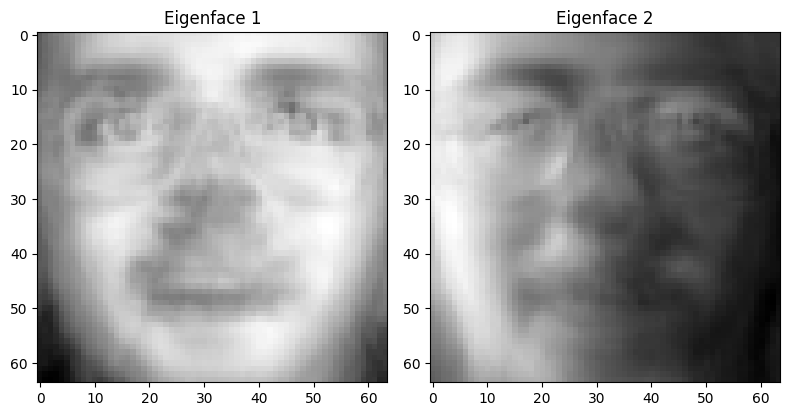

In [9]:
# Perform PCA
eigvecs_face, eigvals_face = pca(X_scaled)

# Reshape the first two principal components to image format
v1 = eigvecs_face[:, 0].reshape(64, 64)
v2 = eigvecs_face[:, 1].reshape(64, 64)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(v1, cmap='gray')
axs[0].set_title('Eigenface 1')
axs[1].imshow(v2, cmap='gray')
axs[1].set_title('Eigenface 2')
plt.tight_layout()
plt.show()


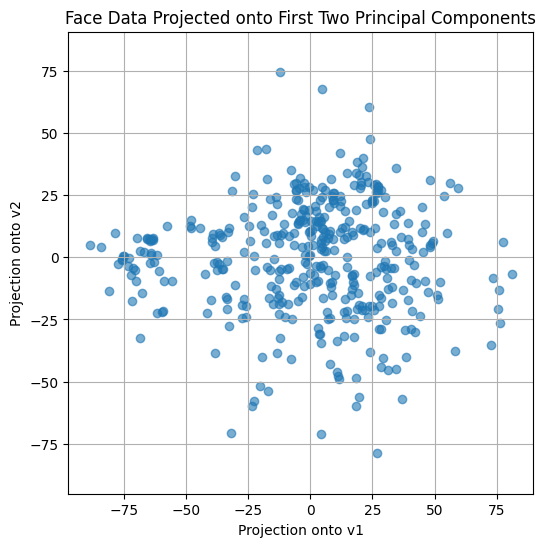

In [10]:
z1 = X_scaled @ eigvecs_face[:, 0]
z2 = X_scaled @ eigvecs_face[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(z1, z2, alpha=0.6)
plt.xlabel('Projection onto v1')
plt.ylabel('Projection onto v2')
plt.title('Face Data Projected onto First Two Principal Components')
plt.grid(True)
plt.axis('equal')
plt.show()


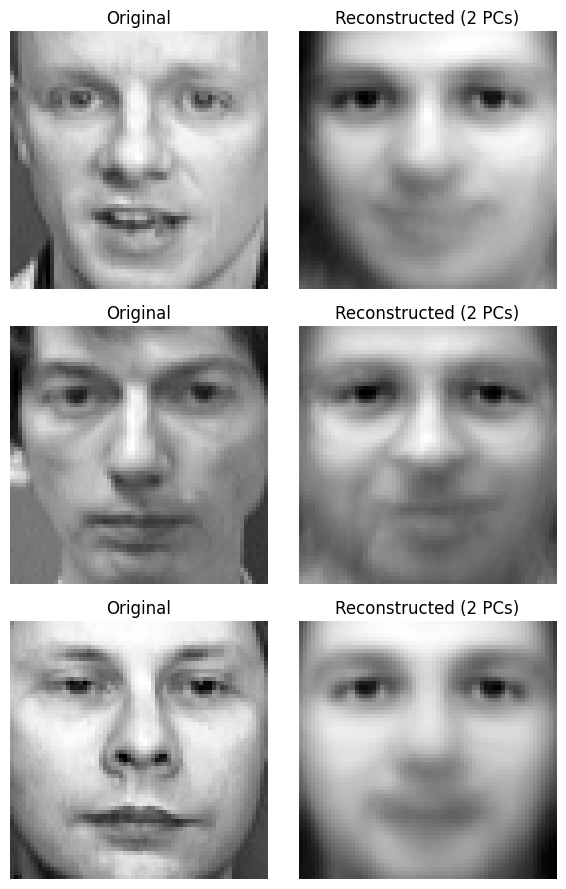

In [11]:
# Select 3 random images
np.random.seed(42)
indices = np.random.choice(len(X_scaled), size=3, replace=False)

# Project and reconstruct
X_proj = X_scaled @ eigvecs_face[:, :2]
X_recon_2pc = X_proj @ eigvecs_face[:, :2].T

# De-standardize
X_recon = scaler.inverse_transform(X_recon_2pc)

# Plot original vs reconstructed
fig, axs = plt.subplots(3, 2, figsize=(6, 9))
for i, idx in enumerate(indices):
    axs[i, 0].imshow(X[idx].reshape(64, 64), cmap='gray')
    axs[i, 0].set_title('Original')
    axs[i, 1].imshow(X_recon[idx].reshape(64, 64), cmap='gray')
    axs[i, 1].set_title('Reconstructed (2 PCs)')
for ax in axs.ravel():
    ax.axis('off')
plt.tight_layout()
plt.show()


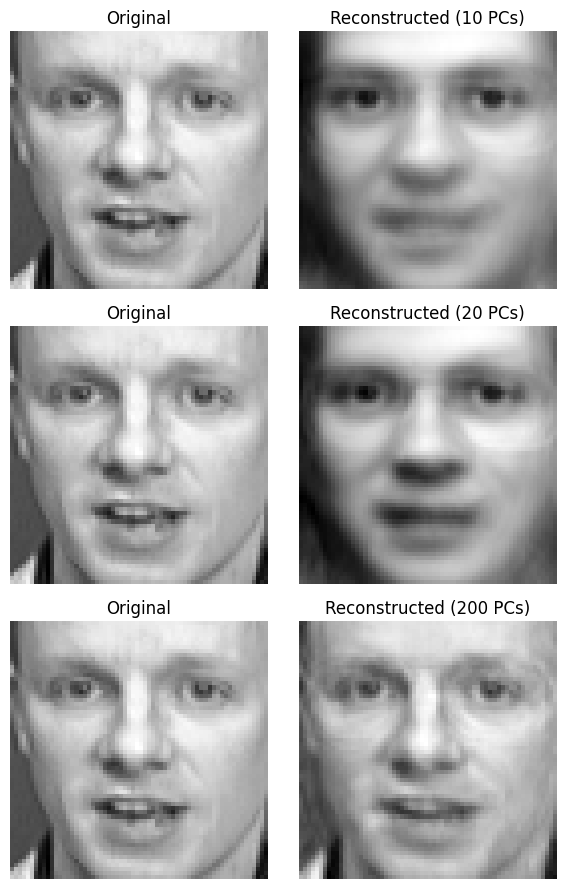

In [12]:
pcs_list = [10, 20, 200]
fig, axs = plt.subplots(len(pcs_list), 2, figsize=(6, 9))
for i, k in enumerate(pcs_list):
    X_proj = X_scaled @ eigvecs_face[:, :k]
    X_recon = X_proj @ eigvecs_face[:, :k].T
    X_recon = scaler.inverse_transform(X_recon)

    axs[i, 0].imshow(X[indices[0]].reshape(64, 64), cmap='gray')
    axs[i, 0].set_title('Original')
    axs[i, 1].imshow(X_recon[indices[0]].reshape(64, 64), cmap='gray')
    axs[i, 1].set_title(f'Reconstructed ({k} PCs)')
    for ax in axs[i]: ax.axis('off')
plt.tight_layout()
plt.show()


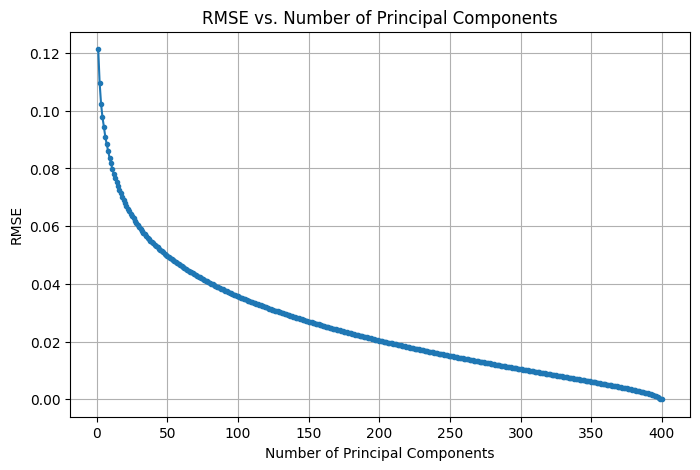

In [13]:
from sklearn.metrics import mean_squared_error

rmse_list = []
components = list(range(1, 401))  # max is 400 because rank <= samples

for k in components:
    X_proj = X_scaled @ eigvecs_face[:, :k]
    X_recon = X_proj @ eigvecs_face[:, :k].T
    X_recon_inv = scaler.inverse_transform(X_recon)
    rmse = np.sqrt(mean_squared_error(X, X_recon_inv))
    rmse_list.append(rmse)

plt.figure(figsize=(8, 5))
plt.plot(components, rmse_list, marker='.')
plt.xlabel('Number of Principal Components')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Principal Components')
plt.grid(True)
plt.show()
